# Using Convoluted Neural Networks to play Doom

This project is heavily based on a paper presented at the 2013 NIPS Deep Learning Workshop by Deepmind, and implemented in Doom using the ViZDoom python environment. The goal is to create and train a convolutional neural network that can interpret pixel data from game frames and choose optimal actions.

The 2013 Deepmind Paper: https://arxiv.org/abs/1312.5602

ViZDoom: https://github.com/mwydmuch/ViZDoom

### Setting up

In [5]:
pip install vizdoom

  Using cached vizdoom-1.1.13-cp39-cp39-win_amd64.whl (15.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
from vizdoom import *
import random
import time
import itertools
from PIL import Image
from skimage import transform
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from collections import deque

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
game = DoomGame() 
game.load_config("ViZDoom/scenarios/health_gathering.cfg")

True

In [9]:
game.set_screen_resolution(RES_1920X1080)
game.set_screen_format(ScreenFormat.RGB24)
game.set_window_visible(True)
game.set_render_hud(False)
game.set_render_crosshair(False)
game.set_render_weapon(False)
game.set_render_decals(False)
game.set_render_particles(False)

Set of actions

In [10]:
turn_left = (1, 0, 0)
turn_right = (0, 1, 0)
move_forward = (0, 0, 1)

actions = [turn_left, turn_right, move_forward]

Code that plays the game for 10 seconds with random actions

In [11]:
game.init()
game.new_episode()

duration = 10
time_start = time.time()

while not game.is_episode_finished():
    reward = game.make_action(random.choice(actions))
    time_passed = time.time() - time_start
    if time_passed >= duration:
        break
game.close()

### Q-learning

Before understanding Q-learning, some terms need to be explained:

- **State** (s): The input information from the game. This can be anything, like a chess board position, but in our case it is pixel data from the game.

- **Action** (a): An action/input that can be executed in the game. For us there are three actions: moving forward, moving left, and moving right.

- **Reward** (r): A number that can be positive or negative that results from taking an action at a certain state. This teaches our algorithm which results it should aim for. For example, winning the game can be +100, losing can be -100. There can be smaller intermediate rewards, like taking damage can be -5 and doing damage can be  +5. The goal is to get the highest total reward at the end of the game as possible.  

Q-learning is a reinforcement algorithm that uses Q-values, which represent the predicted maximum rewards that can be obtained from taking an action. These Q-values are initially random, but are updated after each action taken and becomes more accurate the more the game is played. Formalized, we can write the function for Q-values as:

$$Q(s, a) = E[r + \gamma \max_{a'}Q(s', a')]$$

where

- $E$ represents the expected value
- $\gamma$ is the discount rate, used to counteract overestimation (we will use the value 0.95)
- $a'$ and $s'$ represent the next state and action
- $\max_{a'}Q(s', a')$ representing the highest Q-value of the next state.

We can update the Q-values after each action with the following formulas:

$$Q(s, a) = r \text{ if s' is a terminal state}$$
$$Q(s, a) = r + \gamma \max_{a'}Q(s', a') \text{ if s' is not a terminal state}$$

This can be thought of as a dynamic programming problem, where each Q-value is calculated by breaking down the subproblems of the q-values of the next states, with the initial cases being terinal states where we know the Q-value is equal to the reward. 

The biggest problem of Q-learning is that it is a very primitive and rote algorithm, where each new state is treated individually with a randomly intitialized Q-value, with no consideration in similarities/patterns with other states. This is a problem for us because we will be working with a large amount of pixel data where one small change in pixel value will count as a completely new state. Convolutional neural networks can be used to detect patterns and similarities in the frames and predict the Q-values.

### Pre-Processing the Frames

The game resolution is set to as low as we can go because we will downscale the frame and the lower resolution the input, the more clear it will be preprocessed. Firstly, frames are converted to greyscale in order to cutdown the pixel data drastically, where we only process one color channel instead of three. This may reduce the results as colors can provide important information to the network, but this increases the speed of which our model runs. Next, they are cropped as not the entire screen can be relevant (roofs, health and toolbars, etc.). Then it is resized to a 64x64 image, and the pixel data is normalized. 

In [21]:
game.set_screen_resolution(RES_160X120)

def rgb_to_grey(frame):
    #each cell only has one grey value from 0-255 contrary to RGB which has three
    #Y = 0.2125R + 0.7154G + 0.0721B
    rgb_to_grey = [0.2125, 0.7154, 0.0721]
    frame = np.dot(frame, rgb_to_grey)

    return frame

def preprocess(frame, res, top_crop = 0, bottom_crop = 0, left_crop = 0, right_crop = 0):
    #convert to greyscale so we can only work with one color channel
    frame = rgb_to_grey(frame)

    width = frame.shape[1]
    height = frame.shape[0]
    
    bottom_crop = height - bottom_crop
    left_crop = width - left_crop
    
    #cropping
    frame = frame[top_crop:bottom_crop, right_crop:left_crop]

    #resizing
    frame = transform.resize(frame, res)

    #transform pixel data to range [0, 1]
    frame = frame / 255.0
    
    return frame

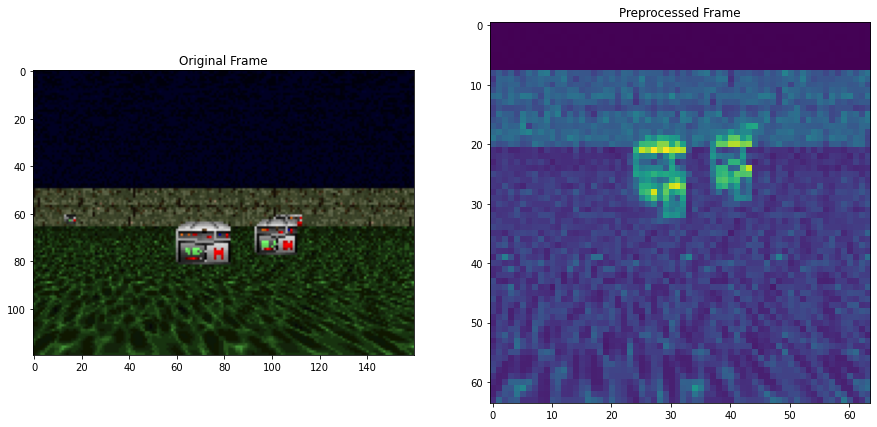

In [13]:
game.set_window_visible(False)
game.init()
orig_frame = game.get_state().screen_buffer
game.close()

res = [64, 64]
preprocessed_frame = preprocess(orig_frame, res, top_crop = 40)

fig, axes = mpl.pyplot.plt.subplots(1, 2, figsize = (15, 15))
axes[0].set_title("Original Frame")
axes[1].set_title("Preprocessed Frame")
axes[0].imshow(orig_frame)
axes[1].imshow(preprocessed_frame)

In [14]:
print(f"Original Frame Shape: {orig_frame.shape} \nPreprocessed Frame Shape: {preprocessed_frame.shape}")

Original Frame Shape: (120, 160, 3) 
Preprocessed Frame Shape: (64, 64)


The deepmind paper processes the frames through what is labeled as a $\phi$ function, which is a description of the frames history. What this is is a stack of the last $n$ frames (we will be using the last 4 frames) that will serve as the input to our model. This is so that our model can take into account movement. If we are turning left for example, that information would not be clear from a single frame, but the last four frames would take that into consideration. So the output is a three dimensional array of four stacked frames, which the dimension is increased in the first axis so as to accomodate the keras input model.

There is also a skip_frame parameter, which only processes every *n*th frame (we also set to 4), because each frame consecutive is very similar to one another and the model doesn't need to process every single frame, so this improves efficiency. It is initialized with 4 completely black frames.

In [22]:
class HistoryFrames:
    def __init__(self, res, history_length, skip_frame = 4):
        self.history_length = history_length
        self.res = res

        #for only appending every xth frame, default is 4th
        self.skip_frame = skip_frame
        self.frame_count = 0

        #making blank frames as an initial starting point, and initilizing the deque and history
        self.empty_state = np.zeros(res)
        self.frames, self.history = None, None
        self.reset()
    
    def next(self, frame):
        #append only xth frame
        self.frame_count += 1
        if not self.frame_count % self.skip_frame == 1: return

        #update deque
        self.frames.appendleft(frame)
        self.frames.pop()
        self._update_state()

    def reset(self):
        self.frames = deque([self.empty_state for i in range(self.history_length)])
        self._update_state()

    def _update_state(self):
        #outputs a four dimensional array (res X 4) of the stacked frames
        #the first "axis" is the amount of samples to be inputted into the model, which is 1
        self.history = np.expand_dims(np.stack(self.frames, axis = 2), axis = 0)

    def state(self):
        return self.history


In [16]:
hf = HistoryFrames([64, 64], 4)

game.set_screen_resolution(RES_160X120)
game.set_window_visible(False)
game.init()

next_frame = preprocess(game.get_state().screen_buffer, res = [64, 64], top_crop = 40)
hf.next(next_frame)
game.close()

hf.state().shape

(1, 64, 64, 4)

### Building the Keras Model

The Google 2013 deepmind paper specifies 4 layers: 

1. A convolutional layer with 16 filters, kernel size 8, stride 4, with relu activation
2. A second convolutional layer with 32 filters, kernel size 4, stride 2, with relu activation
3. An relu activation layer with 256 nodes
4. An output layer with linear activation

There are no pooling layers, however the stride of the convolutional layers downsamples the image. 

In [23]:
inputshape = (64, 64, 4,) #shape of history frame

model =  keras.Sequential([
            keras.Input(shape = inputshape),
            layers.Conv2D(16, kernel_size = (8, 8), strides = (4, 4), activation = "relu"),
            layers.Conv2D(32, kernel_size = (4, 4), strides = (2, 2), activation = "relu"),
            layers.Flatten(),
            layers.Dense(256, activation = "relu"),
            layers.Dense(len(actions), activation = "linear")
        ])

When training our model, we will be backpropagating with mean squared error.

In [31]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = "mse", optimizer = optimizer, metrics = ["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 16)        4112      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          8224      
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 256)               295168    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 308,275
Trainable params: 308,275
Non-trainable params: 0
_________________________________________________________________


### Choosing Actions and Training Replays

Now that the model has been constructed, we can get to choosing actions using each action to update and train our model to be more accurate.

When choosing the most optimal action, the highest predicted Q-value is not necessarily the best action to take even if the model has been trained for a while. This is because the model can be biased towards some actions and choose them over and over again and not have enough information about other possible paths that it can take. Therefore, there must be a random chance of the network choosing to explore and obtain more information to gt a more accurate estimation of all possible Q-values.

We do this by setting an $\epsilon$ variable and choosing a random value $p$ from 0 to 1. If $p < \epsilon$, then a random action will be choosed, otherwise, the action with the highest predicted Q-value will be taken. We will use a decaying $\epsilon$ variable, where the more the model is trained the less random actions it will take. It will start out as 1, and have a minmum value of 0.05, leaving at least a 5% chance to always choose a random action.  

In [25]:
epsilon = 1
epsilon_min = 0.05
epsilon_decay = 0.99

def choose_action(state):
    p = random.random()

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if p < epsilon:
        return random.choice(actions)
    else:
        return actions[np.argmax(model.predict(state))]

To train the model, we use an experience replay (with finite memory, as it can get pretty big pretty fast) that saves our variables at each step. In particular, we save the state, action, reward, the next state, and whether or not the next state is terminal.

In [26]:
replay_memory = deque(maxlen = 5000)

def save_experience_replay(state, action, reward, state_prime, terminal):
    replay_memory.append((state, action, reward, state_prime, terminal))

At each step a random batch of replays are taken and are fitted to the model. This is done randomly, instead of doing them individually at each step, is because training replays consecutively can lead the model to be biased towards certain actions.

To fit the data, the actual $Q(s, a)$ must be calculated using the formula from the Q-learning section, which are:

$$Q(s, a) = r \text{ if s' is a terminal state}$$
$$Q(s, a) = r + \gamma \max_{a'}Q(s', a') \text{ if s' is not a terminal state}$$

We change the values in the predicted $Q^*(s, a)$ and then the entire batch is fit onto the model with only one epoch.

In [27]:
batchsize = 32
gamma = 0.95 #discount rate
    
def train_replays():
    if len(replay_memory) < batchsize:
        return
    
    minibatch = random.sample(replay_memory, batchsize)
            
    states = np.squeeze(np.array([memory[0] for memory in minibatch]))
    state_primes = np.squeeze(np.array([memory[3] for memory in minibatch]))
    
    y = model.predict_on_batch(states)
    Q_prime = gamma * np.max(model.predict_on_batch(state_primes), axis=1)
    
    for i in range(batchsize):
        action = minibatch[i][1]
        reward = minibatch[i][2]
        terminal = minibatch[i][4]
        
        y[i, action] = reward + terminal * Q_prime[i]
    
    model.train_on_batch(states, y)    

### Playing the Game

For each step in an episode:
1. Preprocess the frames into our input state
2. Choose an action based on epsilon-greedy policy and state
3. Record state, action, reward, state', and whether or not state' is the last state
4. Sample a random minibatch from the experience replay and use it to train the model with the Q-learning formula


This function gets the state which preprocesses the frames and obtains the histories of each frame.

In [28]:
def get_state():
    frame = game.get_state().screen_buffer
    frame = preprocess(frame, res, top_crop = 0)
    hf.next(frame)

    return hf.state()

In [ ]:
episodes = 500
game.init()
for i in range(episodes):
    game.new_episode()
    hf.reset()

    state_prime = get_state()

    while not game.is_episode_finished():
        action_prime = choose_action(state_prime)
        reward_prime = game.make_action(action_prime)
        terminal = game.is_episode_finished()

        if not terminal:
            action = action_prime
            reward = reward_prime
            state = state_prime

            state_prime = get_state()
        
        save_experience_replay(state, action, reward, state_prime, terminal)

    print(f"Episode #{i + 1} Total Reward: {game.get_total_reward()}")

game.close()